In [1]:
import sys
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import help_functions as hf
from matplotlib import pyplot as plt
from os.path import exists

### Select the training configuration

In [6]:
# ================== HYPER-PARAMETERS ==================
# config: nr_classes, labels, class_weights, basemodel, image_dimension, results_and_checkpoints_folder, data_folder
i = 0
with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(i)]
old_stdout = sys.stdout

if not exists(config['results_folder'] + '/log_eval.txt'):
    log_file = open(config['results_folder'] + '/log_eval.txt', 'w')
else:
    raise FileExistsError
sys.stdout = log_file

In [7]:
config

{'epochs': 30,
 'augment': False,
 'basemodel': 'EfficientNetB2',
 'nr_classes': 20,
 'batch_size': 512,
 'undersample': False,
 'data_folder': 'data/split_dataframes_heuristic_labels_20221006',
 'loss_function': 'binary_crossentropy',
 'class_weights': False,
 'image_dimension': 64,
 'random_initialization': False,
 'number_trainable_layers': 339,
 'results_folder': 'thesis_experiments/0_imagenet_weights'}

In [8]:
THRESHOLD_MOVE = True

Load test set

/home/matvieir/wiki_image_classification/src/classification/help_functions.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])
/home/matvieir/wiki_image_classification/src/classification/help_functions.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


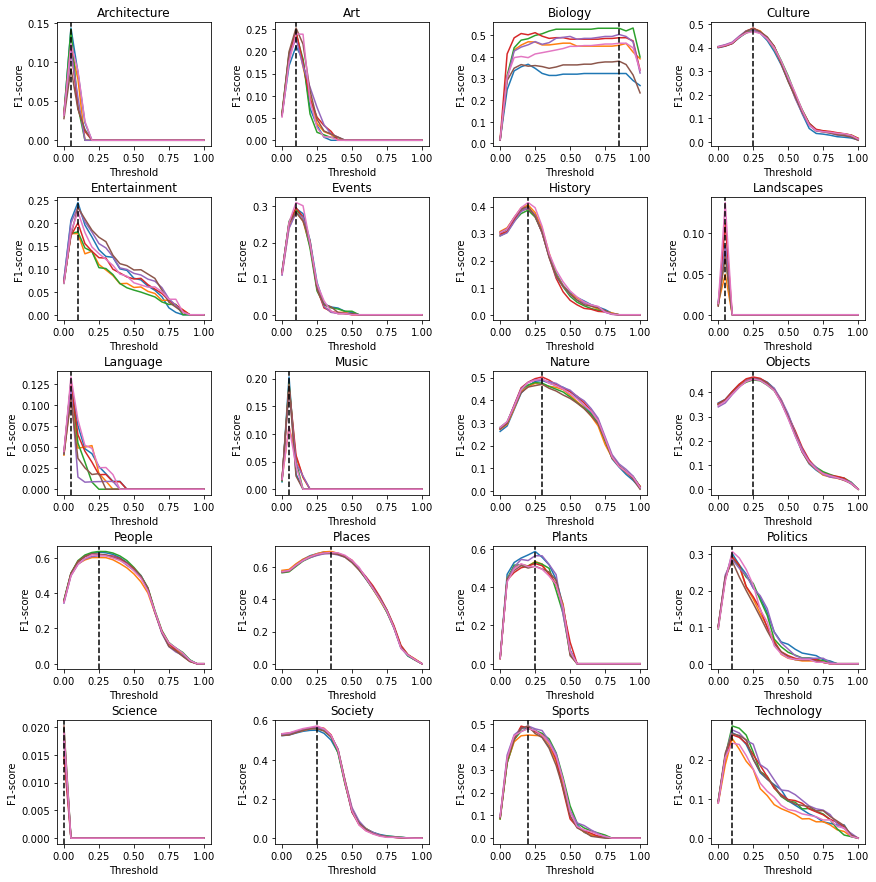

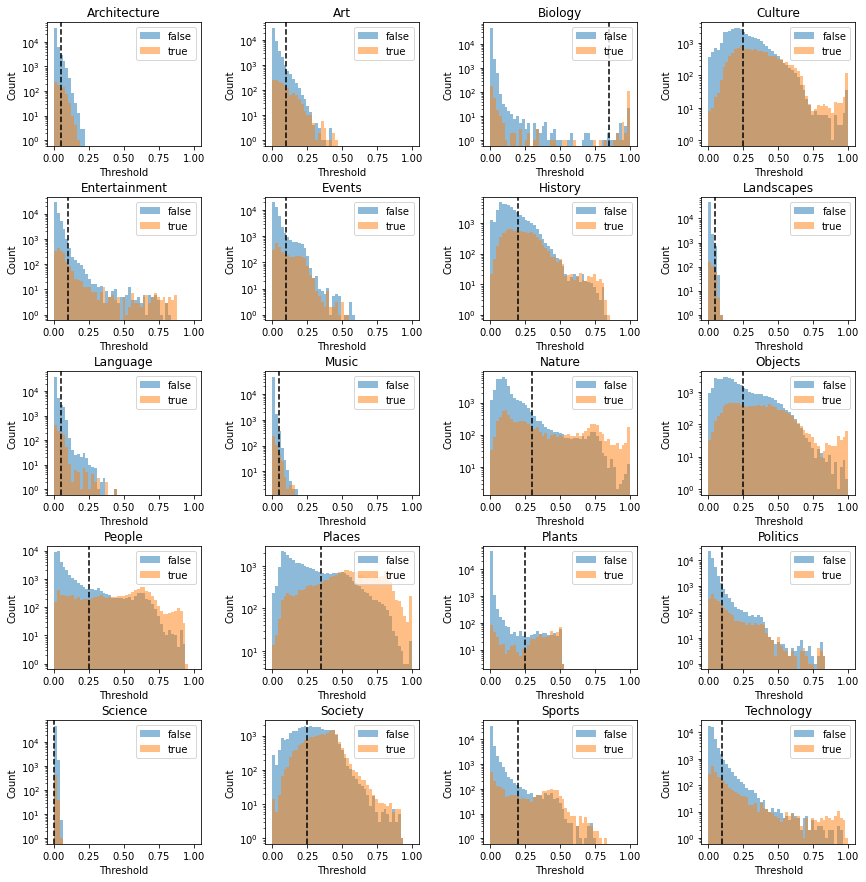

In [9]:
# Load test set
test = hf.get_flow(df_file=config['data_folder'] + '/test_df.json.bz2',
                   nr_classes=config['nr_classes'],
                   image_dimension=config['image_dimension'])

# Create model
model = hf.create_model(n_labels=config['nr_classes'], image_dimension=config['image_dimension'], model_name=config['basemodel'], number_trainable_layers=config['number_trainable_layers'])
latest = tf.train.latest_checkpoint(config['results_folder'] + '/checkpoints')
print(latest)
model.load_weights(latest)

# Predict on test set
print('Predicting on test set:\n')
probs_test = model.predict(test, verbose=2)
y_true_test = hf.get_y_true(shape=(test.samples, len(test.class_indices)), 
                            classes=test.classes)
y_pred_test_05 = 1 * (probs_test > 0.5)

if THRESHOLD_MOVE:
    val_threshold = hf.get_flow(df_file=config['data_folder'] + '/val_threshold_df.json.bz2',
                                nr_classes=config['nr_classes'],
                                image_dimension=config['image_dimension'])
    # Predict on validation set
    print('Predicting on validation set:\n')
    probs_val = model.predict(val_threshold, verbose=2)
    y_true_val = hf.get_y_true(shape=probs_val.shape, classes=val_threshold.classes)
    optim_thresholds = hf.get_optimal_threshold(y_true=y_true_val, 
                                                probs=probs_val, 
                                                thresholds=np.linspace(start=0, stop=1, num=21), 
                                                labels=list(val_threshold.class_indices.keys()), 
                                                N=7,
                                                image_path=config['results_folder'])
    y_pred_test_per_class_threshold = 1 * (probs_test > optim_thresholds)


In [10]:
def plot_f1_scores_side_by_side(f1_scores_05, f1_scores_thresh, image_path):
    plt.figure(figsize=(12, 6))
    x_axis = np.arange(len(f1_scores_05.keys()))
    plt.bar(x_axis-0.1, f1_scores_05.values, width=0.2, label='Threshold 0.5')
    plt.bar(x_axis+0.1, f1_scores_thresh.values, width=0.2, label='Per-class threshold')
    plt.legend(fontsize=12)
    _ = plt.xticks(x_axis, f1_scores_05.keys(), rotation=75, fontsize=14)
    plt.title('F1-scores comparison')
    plt.ylabel('F1-score')
    plt.xlabel('Label')
    try:
        plt.savefig(image_path + '/f1-scores-threshold-moving-or-05.png', bbox_inches='tight')
    except:
        print('Could not save image')

/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


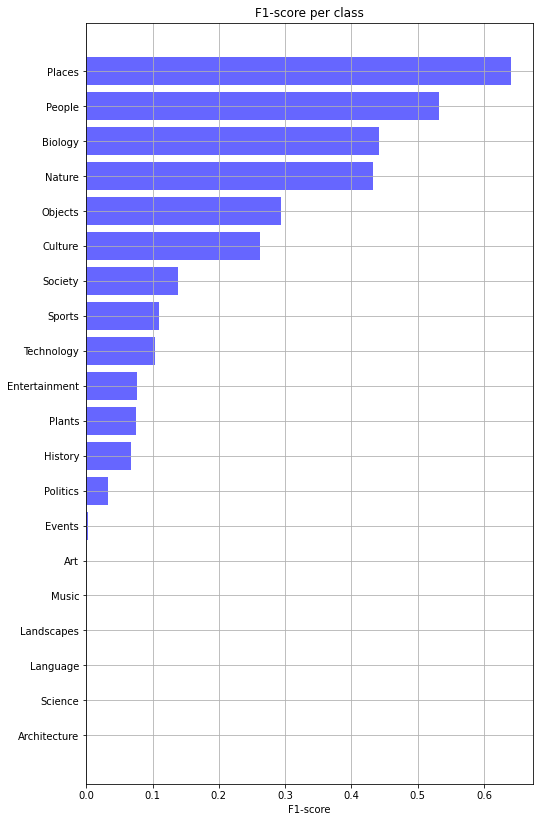

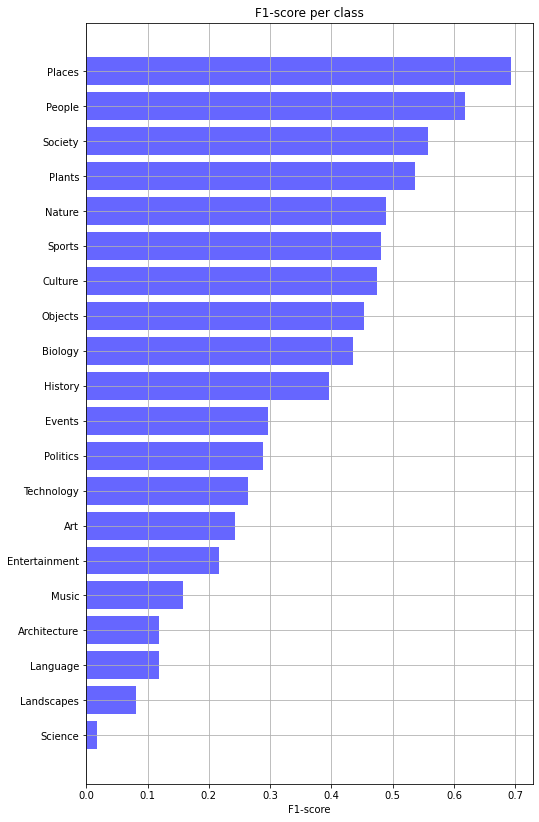

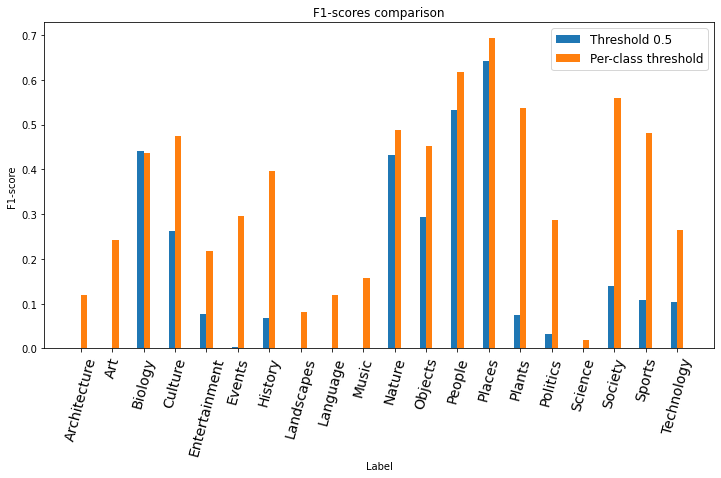

In [11]:
# ================== GET METRICS ======================
print('METRICS FOR THRESHOLD 0.5')
f1_scores_05 = hf.get_metrics(y_true_test, y_pred_test_05, label_names=list(test.class_indices.keys()), image_path=config['results_folder'] + '/f1_scores.png')

if THRESHOLD_MOVE:
    print('METRICS WHEN HAVING PER-CLASS THRESHOLDS')
    f1_scores_thresh = hf.get_metrics(y_true_test, y_pred_test_per_class_threshold, label_names=list(test.class_indices.keys()), image_path=config['results_folder'] + '/f1_scores.png')
    plot_f1_scores_side_by_side(f1_scores_05, f1_scores_thresh, config['results_folder'])

In [12]:
# # ============== CONFUSION MATRICES ===================
# from sklearn.metrics import multilabel_confusion_matrix

# confusion_matrix = multilabel_confusion_matrix(y_true_test, y_pred_test)
# hf.plot_confusion_matrices(confusion_matrix, list(test.class_indices.keys()), config['results_folder'])                                                     
# ======================================================

#### ROC curve for each class

On micro and macro averaging: Micro- and macro-averages (for whatever metric) will compute slightly different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

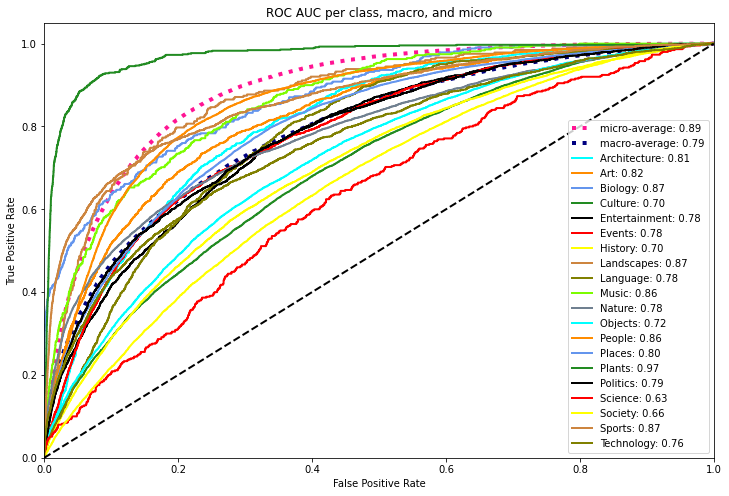

In [13]:
# ================== ROC CURVE PER CLASS ===============
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_roc(y_true, predictions, label_names):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_labels = y_true.shape[1]

    for i in range(n_labels):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    lw = 2
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), predictions.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_labels)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_labels):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_labels

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves

    plt.figure(figsize=(12, 8))

    plt.plot(fpr["micro"],
             tpr["micro"],
             label=f"micro-average: { roc_auc['micro'] :0.2f}",
             color="deeppink",
             linestyle=":",
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label=f"macro-average: { roc_auc['macro'] :0.2f}",
             color="navy",
             linestyle=":",
             linewidth=4)

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "forestgreen", "black", "red", "yellow", "peru", "olive", "lawngreen", "slategray"])
    for i, color in zip(range(n_labels), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label=f"{label_names[i]}: {roc_auc[i]:0.2f}")

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC per class, macro, and micro')
    plt.legend(loc='lower right')
    hf.save_img(config['results_folder'] + '/roc_curves.png')

plot_roc(y_true_test, probs_test, list(test.class_indices.keys()))

In [14]:
sys.stdout = old_stdout

log_file.close()